# VESDE: Variance-exploding SDE

Score-Based Generative Modeling through Stochastic Differential Equations, Song et al., 2020. [[arXiv:2011.13456](https://arxiv.org/abs/2011.13456)]

## 1. Prepare Dataset

Define the gaussian mixture distribution as the target distribution.

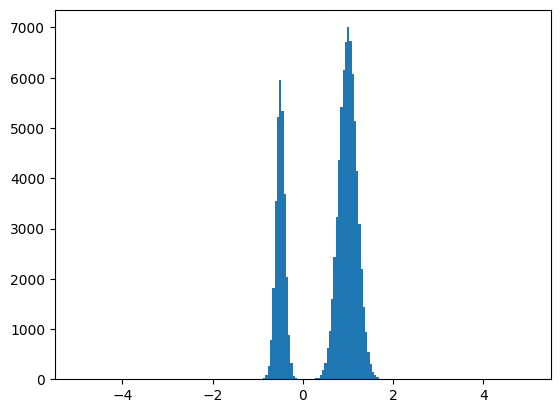

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import gmm

X, Y = gmm(100000, weights=[0.3, 0.7], mean=[-0.5, 1.0], std=[0.1, 0.2])

_ = plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")

## 2. Define Model

Define MLP backbone and VESDE framework.

In [2]:
from flowmodels import VESDE, VESDEScheduler
from utils import Backbone

COND = False
aux = 1 if not COND else 2
scheduler = VESDEScheduler()
model = VESDE(Backbone(aux=aux), scheduler)
model

VESDE(
  (score_estim): Backbone(
    (net): Sequential(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): ReLU()
      (8): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)

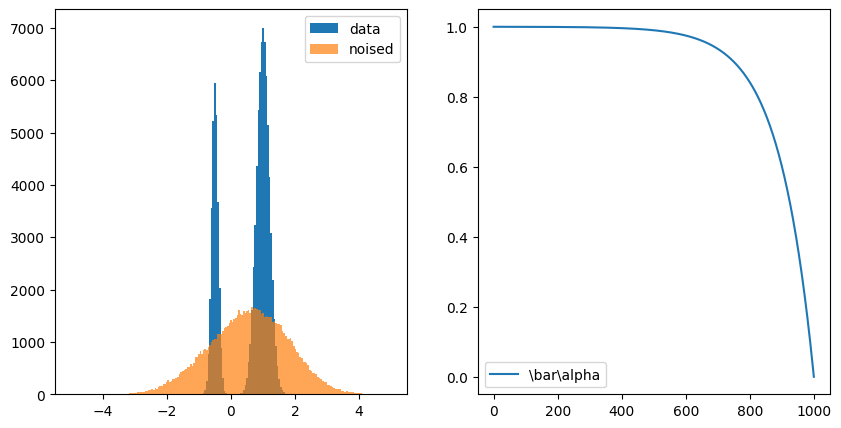

In [3]:
import torch

# intermediate plots
t = (T := 1000) - 1
alpha_bar = 1 - scheduler.var(torch.linspace(0, 1, T))

prior = torch.randn_like(X)
noised = model.noise(X, torch.full((len(X),), 1.0, dtype=torch.long), prior=prior)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

# 1D hists
plt.hist(X, bins=np.linspace(-5, 5, 200), label="data")
plt.hist(noised, bins=np.linspace(-5, 5, 200), label="noised", alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alpha_bar, label="\\bar\\alpha")
plt.legend()

## 3. Train VESDE

Train the score model with the prepared dataset.

  0%|          | 0/1000 [00:00<?, ?it/s]

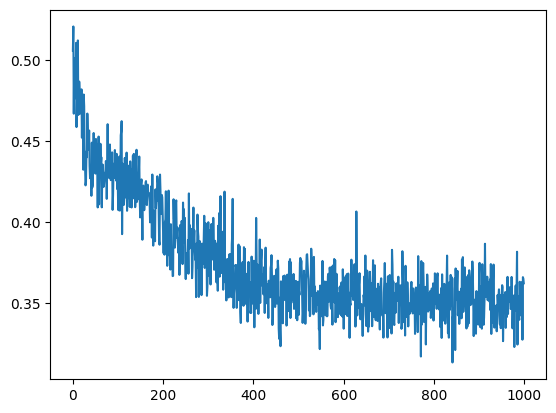

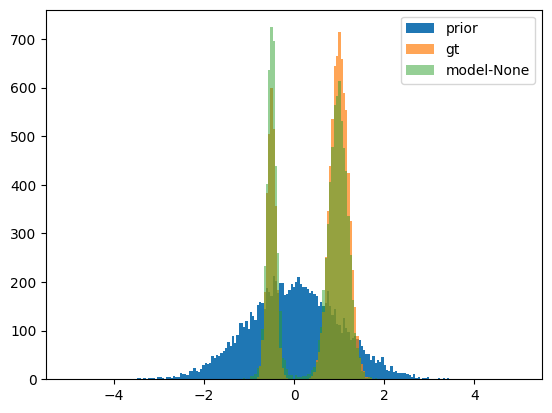

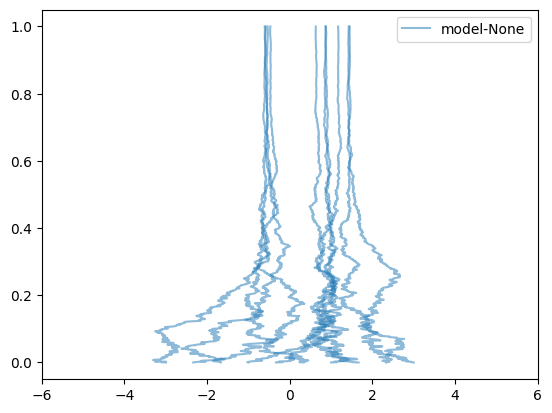

In [4]:
import torch
from tqdm.auto import tqdm

from utils import vis

# training configurations
LR = 0.001
TRAIN_STEPS = 1000
BATCH_SIZE = 2048

# train
model.train()
optim = torch.optim.Adam(model.parameters(), LR)

losses = []
with tqdm(range(TRAIN_STEPS)) as pbar:
    for i in pbar:
        indices = torch.randint(0, len(X), (BATCH_SIZE,))
        loss = model.loss(
            sample=X[indices],
            label=Y[indices] if COND else None,
        )
        # update
        optim.zero_grad()
        loss.backward()
        optim.step()

        # log
        loss = loss.detach().item()
        losses.append(loss)
        pbar.set_postfix_str(f"loss: {loss:.2f}")

plt.plot(losses)
vis(model, conditional=COND, steps=[None])

### PF-ODE: Probability Flow ODE
Score-Based Generative Modeling through Stochastic Differential Equations, Song et al., 2020. [[arXiv:2011.13456](https://arxiv.org/abs/2011.13456)]

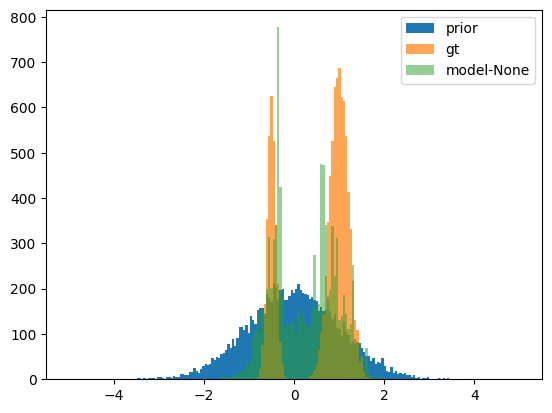

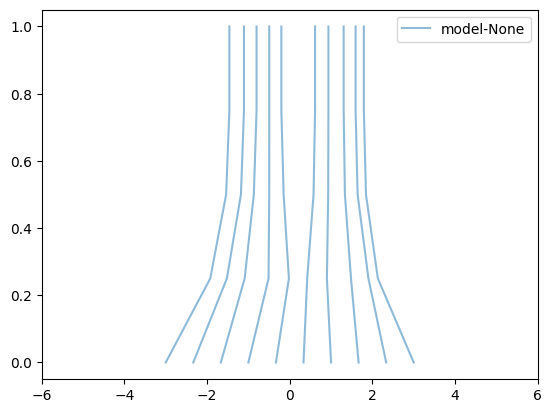

In [5]:
# PF ODE: Score-Based Generative Modeling through Stochastic Differential Equations, Song et al., 2020. [arXiv:2011.13456]
from flowmodels import ProbabilityFlowODESampler


model.sampler = ProbabilityFlowODESampler(model.scheduler)
vis(model, conditional=COND, steps=[None])